# Module 2.- EDA

In [1]:
import pandas as pd
import os
import pyarrow
import contextlib
import io
import matplotlib.pyplot as plt 
from collections import Counter

## Load BDD

In [2]:
PATH = '../../data/'
parquet_files = ["abandoned_carts.parquet","inventory.parquet","orders.parquet", "regulars.parquet", "users.parquet"]

def get_info_middle(df):
    fobj = io.StringIO()
    with contextlib.redirect_stdout(fobj) as stdout:
        df.info()
    fobj.seek(0)
    return '\n'.join(fobj.read().splitlines()[3:-2])

abandoned_carts = pd.read_parquet(PATH + parquet_files[0], engine='pyarrow')
inventory = pd.read_parquet(PATH + parquet_files[1], engine='pyarrow')
orders = pd.read_parquet(PATH + parquet_files[2], engine='pyarrow')
regulars = pd.read_parquet(PATH + parquet_files[3], engine='pyarrow')
users = pd.read_parquet(PATH + parquet_files[4], engine='pyarrow')

In [ ]:
print('#####Abandoned######\n#####')
print(abandoned_carts.info())
print('#####Shape######')
print(abandoned_carts.shape)

print('#####Inventory#####\n#####')
print(inventory.info())
print('#####Shape######')
print(inventory.shape)

In [ ]:

print('#####Orders######\n#####')
print(orders.info())
print('#####Shape######')
print(orders.shape)

print('#####Regulars#####\n#####')
print(regulars.info())
print('#####Shape######')
print(regulars.shape)

In [ ]:
print('#####Users#####\n#####')
print(users.info())
print('#####Shape######')
print(users.shape)

Los datatypes de cada variable son correctos. La unica tabla que contiene Nulls es la de Users, las variables que describen al grupo de usuarios de compra (People, Adults, Children, Babies, Pets), donde People es la que engloba a las demás (sin contar Pets). Para las tablas de ordenes/abandonados los productos se identifican entre comas ','. Vamos a comprobar que no haya duplicidades en registros que deberian ser unicos. 

In [ ]:
def unique_val(dataframe, columna):
    return dataframe[columna].nunique() == dataframe.shape[0]
print('#####Abandoned######')
print(unique_val(abandoned_carts, 'id'))
print('#####Inventoy######')
print(unique_val(inventory, 'variant_id'))
print('#####Orders######')
print(unique_val(orders, 'id'))
print('#####Regulars######')
print(unique_val(regulars, 'user_id'))
print('#####Users######')
print(unique_val(users, 'user_id'))

Con esto Podemos ver que un usuario puede pedir mas de un item como consumo habitual. Comprobaremos tmabien que todos los items del inventario estan en alguna de las tablas que contenga items, es decir, no hay itmes que no estan registrados (el primer nuemro de la lista del diccionario es los items de la tabla key y el segundo numero son los itmes para la tabla inventario)

In [4]:
def check_items(orders_df, regulars_df, abandoned_carts_df, inventory_df):
    items_inventory = inventory_df['variant_id'].unique()

    orders_df = orders_df.explode('ordered_items')
    abandoned_carts_df = abandoned_carts_df.explode('variant_id')
    items_orders = orders_df['ordered_items'].unique()
    items_regulars = regulars_df['variant_id'].unique()
    items_abandoned_carts = abandoned_carts_df['variant_id'].unique()
    problemas = {}
    if len(items_orders) > len(items_inventory):
        problemas['orders'] = [len(items_orders), len(items_inventory)]
    else:
        problemas['orders'] = 'correcto'    
    if len(items_regulars) > len(items_inventory):
        problemas['regulars'] = [len(items_regulars), len(items_inventory)]
    else:
        problemas['regulars'] = 'correcto'
    if len(items_abandoned_carts) > len(items_inventory):
        problemas['abandoned_carts'] = [len(items_abandoned_carts), len(items_inventory)]
    else:
        problemas['abandoned_carts'] = 'correcto'
    return problemas

resultados = check_items(orders_df= orders, regulars_df=regulars, abandoned_carts_df=abandoned_carts, inventory_df=inventory)
print(resultados)

{'orders': [2117, 1733], 'regulars': [1843, 1733], 'abandoned_carts': 'correcto'}


Para las tablas orders y regulars encontramos items que no estan registrados en el inventario y será dificil trackear sus nombres, tipo y propiedades. Hay un 18% de items no trackeados en Orders y un 5% en Regulars.  Esto puede ser debido a un problema al identificar los productos al pasarlos por el lector, que sean items que se externalizan a proveedores no registrados o tambien que un mismo item esté identificado dos veces. Se tendrá en cuenta en prompts siguentes. Idealmente haremos lo mismo para los usuarios.

In [ ]:
def check_users(users_df, orders_df, regulars_df, abandoned_carts_df):
    check_users = users_df['user_id'].unique()
    check_orders = orders_df['user_id'].unique()
    check_regulars = regulars_df['user_id'].unique()
    check_abandoned_carts = abandoned_carts_df['user_id'].unique()
    problemas = {}
    if len(check_orders) > len(check_users):
        problemas['orders'] = [len(check_orders), len(check_users)]
    else:
        problemas['orders'] = 'correcto'    
    if len(check_regulars) > len(check_users):
        problemas['regulars'] = [len(check_regulars), len(check_users)]
    else:
        problemas['regulars'] = 'correcto'
    if len(check_abandoned_carts) > len(check_users):
        problemas['abandoned_carts'] = [len(check_abandoned_carts), len(check_users)]
    else:
        problemas['abandoned_carts'] = 'correcto'
    return problemas

resultados = check_users(users_df=users, orders_df=orders, regulars_df=regulars, abandoned_carts_df=abandoned_carts)
print(resultados)

Los usuarios estan, por contra, todos identificados.

## EDA - Productos

A continuación se presentan algunas hipótesis o análisis descriptivo de los datos que pretenden responder a ciertas preguntas para entender mejor el negocio.

### Items más vendidos

En esta seccion obtendremos un head de los items más y menos vendidos y las clase de item más vendido (en toda la historia de la tienda) con el promedio de ítems de un carrito de compra

In [5]:
def most_item(orders_df, inventory_df):
    len1 = len(orders)
    orders_df = orders_df.explode('ordered_items')
    len2 = len(orders_df)
    avg_items_cart = len2/len1
    item_counts = orders_df['ordered_items'].value_counts().reset_index()
    item_counts.columns = ['Item_ID', 'Cantidad']
    merged_df = item_counts.merge(inventory_df, left_on='Item_ID', right_on='variant_id', how='left')
    return merged_df, avg_items_cart

result1, avg_items = most_item(orders_df=orders, inventory_df=inventory)
print('Los items mas vendidos en la histira de la tienda son:')
print(result1.loc[:,['Item_ID', 'Cantidad', 'price', 'vendor', 'product_type', 'tags']].head(10))
print('\n')
print(f'Un carrito tiene {avg_items:.2f} ítmes en promedio')

Los items mas vendidos en la histira de la tienda son:
          Item_ID  Cantidad  price         vendor  \
0  34081589887108      4487  10.79          oatly   
1  39284117930116      2658    NaN            NaN   
2  34137590366340      1459    NaN            NaN   
3  34081331970180      1170    NaN            NaN   
4  34284951863428      1133   3.69         plenty   
5  34284950356100       954   1.99          fairy   
6  34370361229444       939   4.99  whogivesacrap   
7  33826465153156       884   1.89    clearspring   
8  34284949766276       838   8.49         andrex   
9  34284950454404       683   3.99          lenor   

                      product_type                                       tags  
0       long-life-milk-substitutes                          [oat-milk, vegan]  
1                              NaN                                        NaN  
2                              NaN                                        NaN  
3                              NaN       

In [10]:
print(result1.loc[:,['Item_ID', 'Cantidad', 'price', 'vendor', 'product_type', 'tags']].tail(10))

             Item_ID  Cantidad  price    vendor          product_type  \
2107  33977921241220         1    NaN       NaN                   NaN   
2108  33863279247492         1    NaN       NaN                   NaN   
2109  33826412494980         1    NaN       NaN                   NaN   
2110  34537144123524         1   2.49   piccolo     baby-toddler-food   
2111  39367712866436         1  12.99  gillette      shaving-grooming   
2112  33667312287876         1    NaN       NaN                   NaN   
2113  39686337790084         1   4.59   sudafed  medicines-treatments   
2114  39462725386372         1   5.99  gillette      shaving-grooming   
2115  33667310256260         1    NaN       NaN                   NaN   
2116  33618849693828         1    NaN       NaN                   NaN   

                                                   tags  
2107                                                NaN  
2108                                                NaN  
2109                  

Los productos no registrados aparecen entre los más y menos vendidos y es un problema no poder identificarlos. Es probable que, al ser un historico el dataset, haya habido un renombre de productos. El producto más vendido es leche de avena Oatly y el que menos una afeitadora Gillette (de los que tenemos registro). Podemos cuestionar seguir vendiendolas (teniendo encuenta que es solo un exploratory data-analysis). Los prosuctos mas vendidos por tipo de producto:

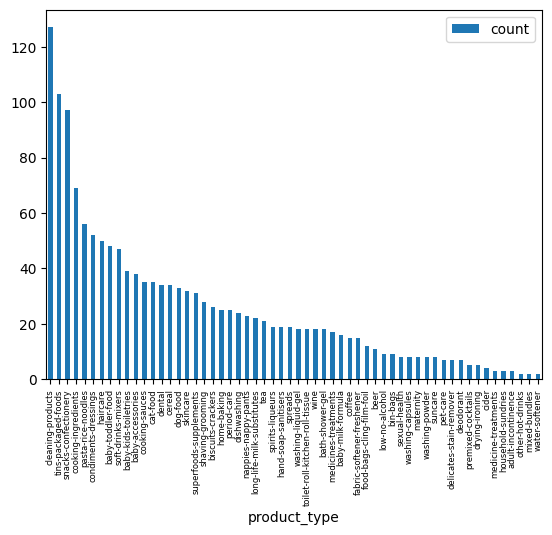

In [16]:
most_product = result1.groupby('product_type')['product_type'].count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
most_product.plot.bar(x='product_type', y='count')
plt.xticks(fontsize=6)
plt.show()

Vemos que los productos mas vendidos (sin contar aquellos no trackeados) son productos de limpieza y productos de comida preparada (cuidado del hogar), lo que se esperaría en el sector de bienes de consumo. Podemos identificar que la tienda tiene un sesgo en productos eco y bio que suelen ser más caros que productos estándar. Podríamos apropximar en cierta medida esta hipótesis mediante la columna "compare_at_price" que indica (suposición) el precio del prodcuto antes de aplicar un descuento. Comprobaremos el ranking de tipos de productos más rebajados.

In [13]:
def calcular_ranking_rebajas(inventory):
    inventory['rebaja_absoluta'] = inventory['compare_at_price'] - inventory['price']
    inventory['rebaja_relativa'] = ((inventory['compare_at_price'] / inventory['price']) - 1) * 100
    grouped = inventory.groupby('product_type').agg({
        'rebaja_absoluta': 'mean',
        'rebaja_relativa': 'mean'
    }).reset_index()

    grouped['ranking_absolutos'] = grouped['rebaja_absoluta'].rank(ascending=False).astype(int)
    grouped['ranking_relativos'] = grouped['rebaja_relativa'].rank(ascending=False).astype(int)
    grouped = grouped.sort_values(['ranking_relativos'], ascending=[True])
    grouped = grouped.rename(columns={
        'product_type': 'Tipo de Producto',
        'ranking_absolutos': 'Ranking Absolutos',
        'rebaja_absoluta': 'Rebaja Absoluta Promedio',
        'ranking_relativos': 'Ranking Relativos',
        'rebaja_relativa': 'Porcentaje de Rebaja Promedio'
    })

    return grouped[['Tipo de Producto', 'Ranking Relativos', 'Porcentaje de Rebaja Promedio', 'Ranking Absolutos', 'Rebaja Absoluta Promedio']]

# Ejemplo de uso
discount = calcular_ranking_rebajas(inventory = inventory)
print(discount.head())

             Tipo de Producto  Ranking Relativos  \
49                    suncare                  1   
17             cooking-sauces                  2   
24  fabric-softener-freshener                  3   
27       hand-soap-sanitisers                  4   
26                   haircare                  5   

    Porcentaje de Rebaja Promedio  Ranking Absolutos  Rebaja Absoluta Promedio  
49                      49.651512                  3                  3.336667  
17                      46.309924                 39                  0.468372  
24                      30.050775                  6                  1.924706  
27                      29.911018                 18                  0.990833  
26                      29.487922                 15                  1.180200  


Los productos mas rebajados son del tipo crema solar y salsa de cocina (casi a la mitad de precio). El descuento de la crema solar implica cobrar 3.3$ menos en promedio por ese tipo de producto y el descuento de las salsas de implica una perdida de 0.46$ promedia por ese tipo de producto. Suponiendo que el dataset fue recogido el 14/03/2022 (ultimo día en el que se recibió un Order), parece una mala politica rebajar la crema solar en invierno (en caso que quiera venderse mas en verano)

### Cesta promedio

In [43]:
def common_cart(orders_df, inventory_df):
    orders_mod = orders_df.copy()
    orders_mod['cesta'] = orders_mod['ordered_items'].astype(str)

    # Realizar un groupby en la columna 'cesta' para contar cuántas veces se repite cada cesta
    cestas_contadas = orders_mod.groupby('cesta').size().reset_index(name='cantidad')
    cesta_mas_comun = cestas_contadas.loc[cestas_contadas['cantidad'].idxmax()]
    cesta_text = pd.DataFrame({'Cesta':[int(e) for e in cesta_mas_comun['cesta'].strip('[]').split()]})
    # Filtrar el DataFrame original para obtener solo la fila de la cesta más común
    #cONTAMOS cantidad productos
    cesta_con_cantidad = cesta_text.groupby('Cesta').size().reset_index(name='cantidad')
    cesta_con_precios = cesta_con_cantidad.merge(inventory_df, left_on='Cesta', right_on='variant_id', how='left')
    cesta_con_precios['precio_total'] = cesta_con_precios['cantidad'] * cesta_con_precios['price']

    return cesta_con_precios
nombres_cesta = common_cart(orders_df=orders, inventory_df=inventory)
print("Cesta Promedio:\n", nombres_cesta)

Cesta Promedio:
             Cesta  cantidad      variant_id  price  compare_at_price vendor  \
0  34081589887108         4  34081589887108  10.79             11.94  oatly   

                 product_type               tags  precio_total  
0  long-life-milk-substitutes  [oat-milk, vegan]         43.16  


La cesta mas comun son cuatro bricks de leche Oatly por un precio total de 43.16$

### Evolucion ordenes

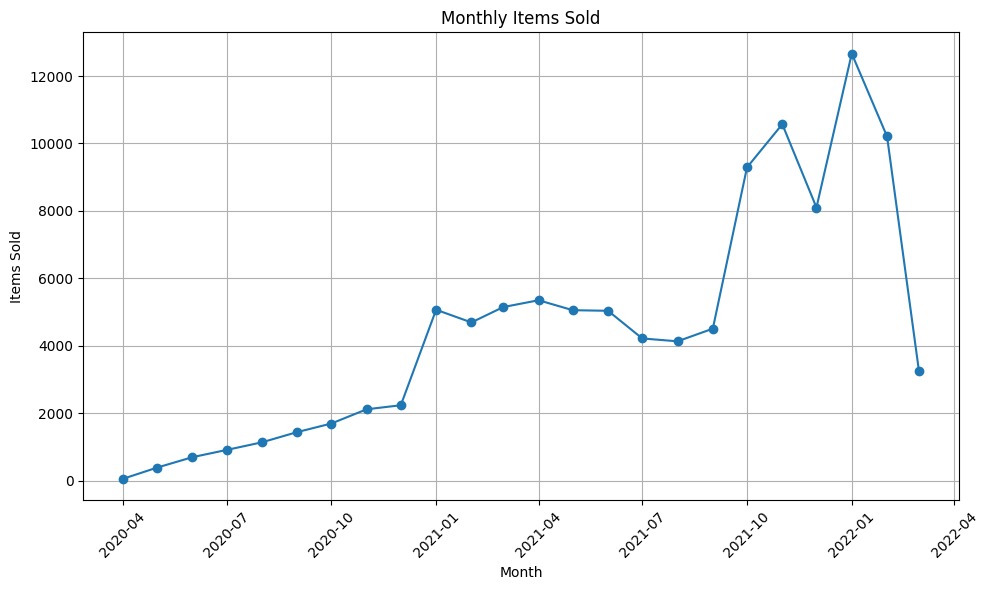

In [5]:
def plot_series_temporales(orders_df):
    orders_df = orders_df.explode('ordered_items')
    monthly_orders = orders_df.groupby(orders_df['order_date'].dt.to_period('M')).size()
    monthly_items_sold_df = pd.DataFrame({'Month': monthly_orders.index.to_timestamp(), 'Items Sold': monthly_orders.values})
    monthly_items_sold_df = monthly_items_sold_df.sort_values(by='Month')

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_items_sold_df['Month'], monthly_items_sold_df['Items Sold'], marker='o', linestyle='-')
    plt.xlabel('Month')
    plt.ylabel('Items Sold')
    plt.title('Monthly Items Sold')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_series_temporales(orders_df=orders)

La evolucion de ventas fue creciente estos años. A finales de cada año hay un spike en las ventas, posiblemente debido a alguna campaña publicitaria en esos periodos. No se observa estacionalidad, pero si mucha volatilidad a partir de Septiembre 2021. Las ordenes bajan considerablemente el ultimo mes, pero puede ser debido a que la muestra acaba el 14/03/2022 y todavia no tenemos desboqueados los datos de todo el mes.